In [ ]:
import kagglehub
import os

path = kagglehub.dataset_download('rohitgrewal/airlines-flights-data')
print('Path Datasheet berada di :', path)
print('Isi folder:', os.listdir(path))

Using Colab cache for faster access to the 'airlines-flights-data' dataset.
Path Datasheet berada di : /kaggle/input/airlines-flights-data
Isi folder: ['airlines_flights_data.csv']


In [ ]:
import pandas as pd

df = pd.read_csv(path + '/airlines_flights_data.csv')
df

,index,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...,...
300148,300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


In [ ]:
df.drop(columns='index', inplace=True)

In [ ]:
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [ ]:
df.describe()

,duration,days_left,price
count,300153.000000,300153.000000,300153.000000
mean,12.221021,26.004751,20889.660523
std,7.191997,13.561004,22697.767366
min,0.830000,1.000000,1105.000000
25%,6.830000,15.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.170000,38.000000,42521.000000
max,49.830000,49.000000,123071.000000


In [ ]:
df.columns

Index(['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'duration', 'days_left',
       'price'],
      dtype='object')

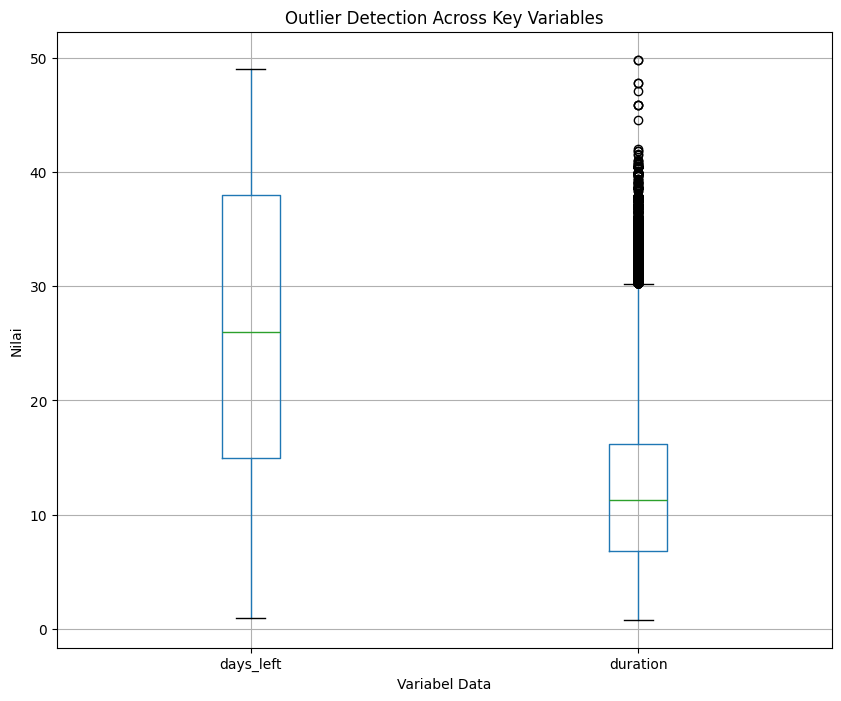

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
df.boxplot(column=['days_left','duration'])
plt.title('Outlier Detection Across Key Variables')
plt.xlabel('Variabel Data')
plt.ylabel('Nilai')
plt.grid(True)
plt.show()

In [ ]:
Features = ['source_city','departure_time','stops', 'arrival_time',
            'destination_city','class','days_left']

In [ ]:
fitur  = df[Features]
target = df['price']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(fitur,target,
                                                    test_size=0.3,
                                                    random_state=42)

In [ ]:
print(f"Data latih:{len(X_train)} observasi dan Data test:{len(X_test)} observasi")

Data latih:210107 observasi dan Data test:90046 observasi


**PREPROCESSING PIPELINE**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer

encoder = StandardScaler()
numeric_features = ['days_left']
numeric_transform = encoder

In [ ]:
ordinal_features = ['class']
class_categories = ['Economy','Business']
ordinal_transform = OrdinalEncoder(categories=[class_categories])

In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder_categ = ['source_city','departure_time','stops','arrival_time','destination_city']
encoder_transform = encoder

In [ ]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transform, numeric_features),
        ('ord', ordinal_transform, ordinal_features),
        ('cat', encoder_transform, encoder_categ)
    ],
    remainder='drop'
)

In [ ]:
import numpy as np

log_transform = FunctionTransformer(np.log1p, inverse_func=np.expm1)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state=42)

In [ ]:
# Wrapper: Model yang membungkus rfr dan otomatis menangani Y
from sklearn.compose import TransformedTargetRegressor

regressor_wrapper = TransformedTargetRegressor(
    regressor=rfr,
    func=log_transform.func,
    inverse_func=log_transform.inverse_func
)

In [ ]:
# Pembangunan Model Pipeline Awal (Estimator untuk GridSearchCV)
rfr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor_wrapper)
])

**HYPERPARAMETER TUNING DENGAN GRIDSEARCHCV**

In [ ]:
# Pembangunan model Pipeline akhir
# PERHATIAN : Gunakan format 'regressor__regressor__parameter_name'
# Di dalam TransformedTargetRegressor ada properti regressor yang menyimpan model rfr

from sklearn.model_selection import GridSearchCV
param_grid = {
    # 1 Jumlah pohon
    'regressor__regressor__n_estimators':[100,200,],
    # 2 Kedalaman pohon
    'regressor__regressor__max_depth':[5,15],
    # 3 Jumlah sampel minimum untuk split
    'regressor__regressor__min_samples_split':[2 , 5]
}

In [ ]:
# Inisialisasi GridSearchCV
grid_search = GridSearchCV(
    estimator=rfr_pipeline,
    param_grid=param_grid,
    cv=3, #Cross validation
    scoring='neg_mean_squared_error',
    n_jobs=2,
    verbose=1

)

In [ ]:
print("Memulai pencarian Grid... Proses ini akan melatih pipeline berulang kali")
grid_search.fit(X_train, y_train)
print("Pencarian Grid Selesai")

Memulai pencarian Grid... Proses ini akan melatih pipeline berulang kali
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Pencarian Grid Selesai


In [ ]:
# best_estimators adalah pipeline final yang sudah di tune
best_model = grid_search.best_estimator_

In [ ]:
print("\n ==== Hasil Tuning =====")
print(f"Parameter terbaik : {grid_search.best_params_}")
print(f"Skor terbaik CV (Neg.MSE):{grid_search.best_score_:.4f}")


 ==== Hasil Tuning =====
Parameter terbaik : {'regressor__regressor__max_depth': 15, 'regressor__regressor__min_samples_split': 5, 'regressor__regressor__n_estimators': 200}
Skor terbaik CV (Neg.MSE):-23858415.8807


**TESTING DAN HASIL EVALUASI MODEL**

In [ ]:
y_pred = best_model.predict(X_test)

**HASIL EVALUASI**

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print('\n --- Hasil Evaluasi pada Data Uji ---')
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse  = mean_absolute_error(y_test,y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f'MSE (Mean Absolute Error): {mse:.4f}')
print(f"R-Squared (R2 Score): {r2:.4f}")
print(f'Harga Aktual Data Uji:\n{y_test.values}')
print(f"Harga Prediksi (Skala asli):\n{np.round(y_pred,2)}")



 --- Hasil Evaluasi pada Data Uji ---
RMSE (Root Mean Squared Error): 4882.4682
MSE (Mean Absolute Error): 2808.1478
R-Squared (R2 Score): 0.9537
Harga Aktual Data Uji:
[ 7366 64831  6195 ...  2410  2835  3393]
Harga Prediksi (Skala asli):
[ 5194.39 61013.99  5990.83 ...  2432.62  4351.02  3445.72]


**VISUALISASI**

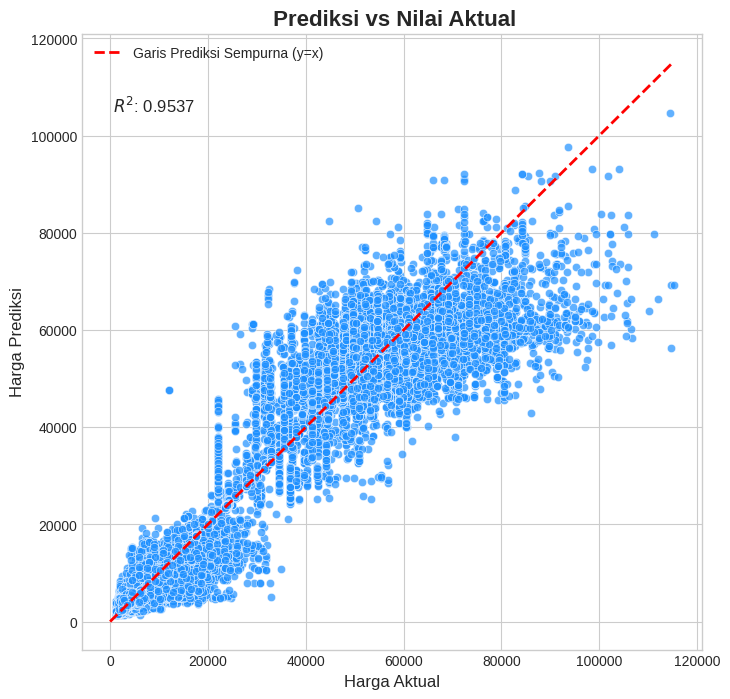

In [ ]:
import seaborn as sns
seaborn_version = 'seaborn-v0_8-whitegrid'

plt.figure(figsize=(8,8))
plt.style.use(seaborn_version)

sns.scatterplot(x=y_test, y=y_pred, color='dodgerblue', alpha=0.7)
max_val = max(y_test.max(), y_pred.max())
y_pred.max()

plt.plot([0, max_val], [0,max_val], 'r--', lw=2, label='Garis Prediksi Sempurna (y=x)')
plt.title(" Prediksi vs Nilai Aktual", fontsize=16, fontweight='bold')
plt.xlabel('Harga Aktual', fontsize=12)
plt.ylabel('Harga Prediksi', fontsize=12)
plt.legend()
plt.text(0.05, 0.9, f'$R^2$: {r2:.4f}', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top')
plt.show()

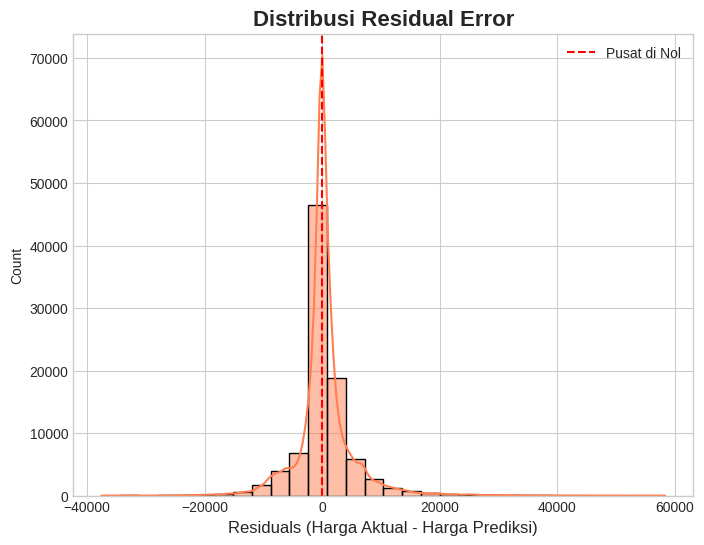

In [ ]:
residual = y_test - y_pred

plt.figure(figsize=(8,6))
plt.style.use(seaborn_version)

sns.histplot(residual, kde=True, color='coral', bins=30)
plt.title('Distribusi Residual Error', fontsize=16, fontweight='bold')
plt.xlabel('Residuals (Harga Aktual - Harga Prediksi)', fontsize=12)
plt.axvline(0, color='r', linestyle='--', label='Pusat di Nol')
plt.legend()
plt.show()

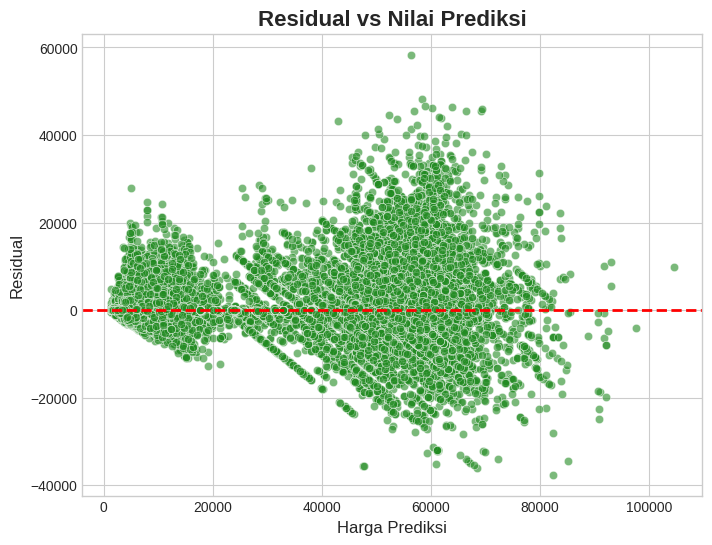

In [ ]:
plt.figure(figsize=(8,6))
plt.style.use(seaborn_version)

sns.scatterplot(x=y_pred, y=residual, color='forestgreen', alpha=0.6)
plt.axhline(0, color='r', linestyle='--', lw=2) # Garis residual nol
plt.title('Residual vs Nilai Prediksi', fontsize=16, fontweight='bold')
plt.xlabel('Harga Prediksi', fontsize=12)
plt.ylabel('Residual', fontsize=12)
plt.show()

/tmp/ipython-input-655446407.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


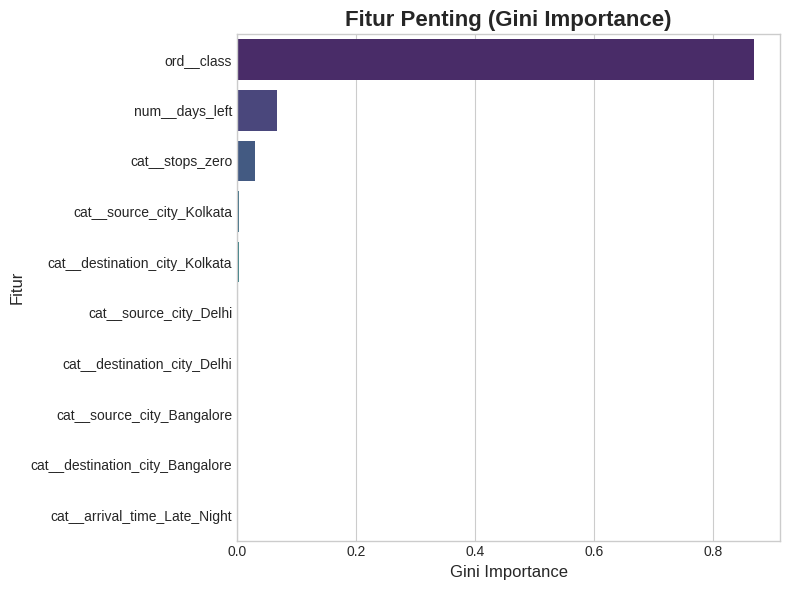

In [ ]:
# Feature Importance

TransformedTargetRegressor
rfr_best = best_model.named_steps['regressor'].regressor_
importances = rfr_best.feature_importances_

feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance':importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,6))
plt.style.use(seaborn_version)
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Fitur Penting (Gini Importance)', fontsize=16, fontweight='bold')
plt.xlabel('Gini Importance', fontsize=12)
plt.ylabel('Fitur', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [ ]:
new_data = pd.DataFrame([{
    'source_city':'Delhi',
    'departure_time':'Morning',
    'stops':'zero',
    'arrival_time':'Morning',
    'destination_city':'Mumbai',
    'class':'Economy',
    'days_left': 1
}])


In [ ]:
y_new = best_model.predict(new_data)

In [ ]:
print("Prediksi Harga Tiket untuk data baru:")
print(f" {y_new[0]:,.2f}")

Prediksi Harga Tiket untuk data baru:
 6,258.62


In [ ]:
from google.colab import files
import joblib

joblib.dump(best_model,"rfr-flight_price_prediction.pkl")
files.download('rfr-flight_price_prediction')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>